<a href="https://colab.research.google.com/github/toledotorrespatricio/hjb-nn-mmcc/blob/main/sls_20250731_05_03_01_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# VERSIÓN MEJORADA: Con normalización de costos según la imagen
# ============================================================================
import os, datetime, numpy as np, tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configuración GPU
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

DEVICE = '/GPU:0' if gpus else '/CPU:0'
print("🔧  Usando dispositivo:", DEVICE)

# TensorBoard
log_dir = "logs/slscheme_improved/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = tf.summary.create_file_writer(log_dir)

with tf.device(DEVICE):
    # -----------------------------------------------------------------------
    # 1) PARÁMETROS DEL SISTEMA
    # -----------------------------------------------------------------------
    C1, C2, C3 = 1_000.0, 5_000.0, 1e-3

    A_mat = tf.constant([[1., 0., .5],
                         [0., 1., .5]], dtype=tf.float32)
    A_pinv = tf.linalg.pinv(A_mat)

    K_mat = tf.constant([[ 2/3, -1/3, -1/3],
                         [-1/3,  2/3, -1/3],
                         [-1/3, -1/3,  2/3]], dtype=tf.float32)

    state_dim, control_dim = 7, 3
    x_min, x_max = 0., 1_000.
    y_min, y_max = -15., 15.
    u_min, u_max = -1., 1.
    λ_w, λ_x, λ_z, λ_u = 0.5, 0.3, 0.1, 0.1

    # -----------------------------------------------------------------------
    # PARÁMETROS DE NORMALIZACIÓN DE COSTOS
    # -----------------------------------------------------------------------
    # Límites esperados para cada error (basados en el sistema)
    # Error w: Ay - w_ref
    e_w_min = tf.constant([-20., -10.], dtype=tf.float32)  # Min esperado
    e_w_max = tf.constant([20., 10.], dtype=tf.float32)    # Max esperado

    # Error x: x - x_ref
    e_x_min = tf.constant([-880., -880., -880.], dtype=tf.float32)
    e_x_max = tf.constant([120., 120., 120.], dtype=tf.float32)

    # Error z: (I - A^T A)y
    e_z_min = tf.constant([-15., -15., -15.], dtype=tf.float32)
    e_z_max = tf.constant([15., 15., 15.], dtype=tf.float32)

    # Error u: A^T d(t) - K diag{x} u
    e_u_min = tf.constant([-1000., -1000., -1000.], dtype=tf.float32)
    e_u_max = tf.constant([1000., 1000., 1000.], dtype=tf.float32)

    # Calcular e_DC y e_peak para cada error
    e_w_DC = (e_w_max + e_w_min) / 2.0
    e_w_peak = (e_w_max - e_w_min) / 2.0

    e_x_DC = (e_x_max + e_x_min) / 2.0
    e_x_peak = (e_x_max - e_x_min) / 2.0

    e_z_DC = (e_z_max + e_z_min) / 2.0
    e_z_peak = (e_z_max - e_z_min) / 2.0

    e_u_DC = (e_u_max + e_u_min) / 2.0
    e_u_peak = (e_u_max - e_u_min) / 2.0

    # Calcular E_k,N^2 para normalización
    E_w_N_sq = tf.reduce_sum(e_w_DC**2) + 0.5 * tf.reduce_sum(e_w_peak**2)
    E_x_N_sq = tf.reduce_sum(e_x_DC**2) + 0.5 * tf.reduce_sum(e_x_peak**2)
    E_z_N_sq = tf.reduce_sum(e_z_DC**2) + 0.5 * tf.reduce_sum(e_z_peak**2)
    E_u_N_sq = tf.reduce_sum(e_u_DC**2) + 0.5 * tf.reduce_sum(e_u_peak**2)

    # -----------------------------------------------------------------------
    # NORMALIZACIÓN (CRÍTICO!)
    # -----------------------------------------------------------------------
    # Factores de normalización para llevar todo a [-1, 1]
    x_scale = (x_max - x_min) / 2.0
    x_offset = (x_max + x_min) / 2.0
    y_scale = (y_max - y_min) / 2.0
    y_offset = (y_max + y_min) / 2.0

    @tf.function
    def normalize_state(state):
        """Normaliza estado a [-1, 1]"""
        x, y, z = state[:, :3], state[:, 3:6], state[:, 6:7]
        x_norm = (x - x_offset) / x_scale
        y_norm = (y - y_offset) / y_scale
        z_norm = z / 10.0  # Normalizar costo acumulado (ajustado para nuevos costos)
        return tf.concat([x_norm, y_norm, z_norm], axis=1)

    @tf.function
    def denormalize_state(state_norm):
        """Desnormaliza estado"""
        x_norm, y_norm, z_norm = state_norm[:, :3], state_norm[:, 3:6], state_norm[:, 6:7]
        x = x_norm * x_scale + x_offset
        y = y_norm * y_scale + y_offset
        z = z_norm * 10.0
        return tf.concat([x, y, z], axis=1)

    # -----------------------------------------------------------------------
    # 2) DISCRETIZACIÓN TEMPORAL
    # -----------------------------------------------------------------------
    T, N, p = 0.4, 100, 10  # Reducido N para pruebas más rápidas
    dt = T / N

    # -----------------------------------------------------------------------
    # 3) REFERENCIAS
    # -----------------------------------------------------------------------
    @tf.function
    def w_ref(t):
        val = 5.0 * tf.cos(40.0 * np.pi * t)
        return tf.stack([15.0, val], axis=0)[None, :]

    x_ref = tf.constant([[880., 880., 880.]], tf.float32)

    @tf.function
    def d_ref(t):
        val = 300. * tf.cos(40. * np.pi * t)
        return tf.stack([500.0, val], axis=0)[None, :]

    # -----------------------------------------------------------------------
    # 4) DINÁMICA AUMENTADA CON CLIPPING
    # -----------------------------------------------------------------------
    @tf.function
    def f_aug(state, u, t):
        x, y = state[:, :3], state[:, 3:6]

        # Limitar valores para evitar explosión
        x = tf.clip_by_value(x, x_min, x_max)
        y = tf.clip_by_value(y, y_min, y_max)
        u = tf.clip_by_value(u, u_min, u_max)

        dx = C1 * y * u

        dvec = tf.repeat(d_ref(t), tf.shape(state)[0], axis=0)
        ATd = tf.matmul(dvec, A_mat)

        Kxu = tf.matmul(x * u, K_mat, transpose_b=True)
        dy = C2 * (-C3 * y + ATd - Kxu)

        # Calcular errores según la imagen
        wvec = tf.repeat(w_ref(t), tf.shape(state)[0], axis=0)
        e_w = tf.matmul(y, A_mat, transpose_b=True) - wvec  # Error de posición

        x_ref_repeated = tf.repeat(x_ref, tf.shape(state)[0], axis=0)
        e_x = x - x_ref_repeated  # Error de estado

        zmat = tf.eye(3) - tf.matmul(A_pinv, A_mat)
        e_z = tf.matmul(y, zmat, transpose_b=True)  # Error de espacio nulo

        e_u = ATd - Kxu  # Error de esfuerzo de control

        # Costos normalizados según la formulación de la imagen
        Jw = tf.reduce_sum(e_w**2, axis=1, keepdims=True) / E_w_N_sq
        Jx = tf.reduce_sum(e_x**2, axis=1, keepdims=True) / E_x_N_sq
        Jz = tf.reduce_sum(e_z**2, axis=1, keepdims=True) / E_z_N_sq
        Ju = tf.reduce_sum(e_u**2, axis=1, keepdims=True) / E_u_N_sq

        Lval = λ_w*Jw + λ_x*Jx + λ_z*Jz + λ_u*Ju

        # Limitar gradientes
        dx = tf.clip_by_value(dx, -1000., 1000.)
        dy = tf.clip_by_value(dy, -100., 100.)
        Lval = tf.clip_by_value(Lval, 0., 10.)  # Ajustado para costos normalizados

        return tf.concat([dx, dy, Lval], 1)

    # -----------------------------------------------------------------------
    # 5) FUNCIONES AUXILIARES
    # -----------------------------------------------------------------------
    @tf.function
    def g_obstacle(state):
        x, y = state[:, :3], state[:, 3:6]
        vx = tf.maximum(x_min - x, x - x_max)
        vy = tf.maximum(y_min - y, y - y_max)
        violation = tf.maximum(tf.reduce_max(vx, 1), tf.reduce_max(vy, 1))
        return tf.clip_by_value(violation, -10., 10.)  # Limitar penalización

    @tf.function
    def phi_terminal(state):
        return tf.clip_by_value(state[:, 6], 0., 100.)  # Ajustado para costos normalizados

    def sample_states(batch):
        """Muestreo más inteligente"""
        # 80% cerca del centro, 20% en extremos
        if tf.random.uniform([]) < 0.8:
            x = tf.random.normal([batch, 3], mean=500., stddev=200.)
            y = tf.random.normal([batch, 3], mean=0., stddev=5.)
        else:
            x = tf.random.uniform([batch, 3], x_min, x_max)
            y = tf.random.uniform([batch, 3], y_min, y_max)

        x = tf.clip_by_value(x, x_min, x_max)
        y = tf.clip_by_value(y, y_min, y_max)
        z = tf.zeros([batch, 1])
        return tf.concat([x, y, z], 1)

    # -----------------------------------------------------------------------
    # 6) OPERADORES F_a y G_a
    # -----------------------------------------------------------------------
    @tf.function
    def F_a(state, u, t0):
        """Propaga estado - IMPORTANTE: state debe estar en escala original"""
        s, t = state, t0
        dt_p = dt / p
        for _ in tf.range(p):
            s += dt_p * f_aug(s, u, t)
            s = tf.concat([tf.clip_by_value(s[:, :3], x_min, x_max),
                          tf.clip_by_value(s[:, 3:6], y_min, y_max),
                          s[:, 6:]], 1)
            t += dt_p
        return s  # Retorna en escala original

    @tf.function
    def G_a(state, u, t0):
        """Calcula violaciones - IMPORTANTE: state debe estar en escala original"""
        s, t = state, t0
        m = tf.zeros([tf.shape(state)[0]])  # Inicializar en 0, no -inf
        dt_p = dt / p
        for _ in tf.range(p):
            s += dt_p * f_aug(s, u, t)
            s = tf.concat([tf.clip_by_value(s[:, :3], x_min, x_max),
                          tf.clip_by_value(s[:, 3:6], y_min, y_max),
                          s[:, 6:]], 1)
            m = tf.maximum(m, g_obstacle(s))
            t += dt_p
        return m

    # -----------------------------------------------------------------------
    # 7) REDES NEURONALES MEJORADAS
    # -----------------------------------------------------------------------
    def create_control_net():
        """Red con regularización y normalización"""
        return tf.keras.Sequential([
            tf.keras.layers.Input((state_dim,)),
            tf.keras.layers.Lambda(normalize_state),  # Normalizar entrada
            tf.keras.layers.Dense(24, activation='relu',
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(16, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(control_dim, activation='tanh')
        ])

    def create_value_net():
        """Red de valor con normalización"""
        return tf.keras.Sequential([
            tf.keras.layers.Input((state_dim,)),
            tf.keras.layers.Lambda(normalize_state),  # Normalizar entrada
            tf.keras.layers.Dense(24, activation='relu',
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(24, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1)
        ])

    # Crear redes
    control_nets = [create_control_net() for _ in range(N)]
    value_nets = [create_value_net() for _ in range(N)]
    value_nets.append(None)

    # Optimizadores con learning rate más conservador
    opt_u = [tf.keras.optimizers.Adam(5e-4, clipnorm=1.0) for _ in range(N)]
    opt_V = [tf.keras.optimizers.Adam(5e-4, clipnorm=1.0) for _ in range(N)]

    # -----------------------------------------------------------------------
    # 8) ENTRENAMIENTO MEJORADO
    # -----------------------------------------------------------------------
    epochs_ctrl = 30  # Más épocas
    epochs_val = 30
    bs = 128  # Batch más grande

    # Para early stopping
    patience = 5
    min_delta = 1e-3

    print("🚀 Iniciando entrenamiento mejorado...")

    for n in reversed(range(N)):
        t0 = tf.constant(float(n)*dt, tf.float32)
        print(f"\n=== Paso {n}/{N-1} ===")

        # Entrenar control
        best_loss = float('inf')
        no_improve = 0

        for e in range(1, epochs_ctrl+1):
            S = sample_states(bs)  # Estados en escala original

            with tf.GradientTape() as g:
                u = control_nets[n](S, training=True)  # La red normaliza internamente
                u = tf.clip_by_value(u, u_min, u_max)

                if n + 1 == N:
                    T = tf.maximum(G_a(S, u, t0), phi_terminal(F_a(S, u, t0)))
                else:
                    next_state = F_a(S, u, t0)  # Estado en escala original
                    # IMPORTANTE: La red n+1 espera estados originales (se normalizan internamente)
                    next_value = value_nets[n+1](next_state, training=False)
                    T = tf.maximum(G_a(S, u, t0), tf.squeeze(next_value))

                # Añadir pequeña regularización
                T = tf.clip_by_value(T, 0., 100.)
                loss = tf.reduce_mean(T) + 1e-6 * tf.reduce_sum([tf.nn.l2_loss(w)
                                                                  for w in control_nets[n].trainable_weights])

            grads = g.gradient(loss, control_nets[n].trainable_variables)
            if all(g is not None for g in grads):
                opt_u[n].apply_gradients(zip(grads, control_nets[n].trainable_variables))

            # Early stopping
            if loss < best_loss - min_delta:
                best_loss = loss
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                print(f"  Early stopping en época {e}")
                break

            if e % 10 == 0:
                print(f"  ctrl epoch {e} loss {loss.numpy():.6f}")

        # Entrenar valor (similar)
        best_loss_v = float('inf')
        no_improve_v = 0

        for e in range(1, epochs_val+1):
            S = sample_states(bs)
            u = control_nets[n](S, training=False)
            u = tf.clip_by_value(u, u_min, u_max)

            if n + 1 == N:
                T = tf.maximum(G_a(S, u, t0), phi_terminal(F_a(S, u, t0)))
            else:
                next_state = F_a(S, u, t0)
                next_value = value_nets[n+1](next_state, training=False)
                T = tf.maximum(G_a(S, u, t0), tf.squeeze(next_value))

            with tf.GradientTape() as gV:
                pred = tf.squeeze(value_nets[n](S, training=True))
                T_clipped = tf.clip_by_value(tf.stop_gradient(T), 0., 100.)
                lossV = tf.reduce_mean((pred - T_clipped)**2)

            grads_V = gV.gradient(lossV, value_nets[n].trainable_variables)
            if all(g is not None for g in grads_V):
                opt_V[n].apply_gradients(zip(grads_V, value_nets[n].trainable_variables))

            if lossV < best_loss_v - min_delta:
                best_loss_v = lossV
                no_improve_v = 0
            else:
                no_improve_v += 1

            if no_improve_v >= patience:
                print(f"  Early stopping valor en época {e}")
                break

            if e % 10 == 0:
                print(f"  val epoch {e} loss {lossV.numpy():.6f}")

    # -----------------------------------------------------------------------
    # 9) SIMULACIÓN
    # -----------------------------------------------------------------------
    def control_trajectory_SL(x0):
        s = tf.convert_to_tensor(x0[None, :], tf.float32)
        traj, u_seq = [x0.copy()], []
        t = tf.constant(0., tf.float32)

        for n in range(N):
            u = control_nets[n](s, training=False)
            u = tf.clip_by_value(u, u_min, u_max)
            u_seq.append(u.numpy()[0])
            s = F_a(s, u, t)
            traj.append(s.numpy()[0])
            t += dt

        return np.array(traj), np.array(u_seq)

# ============================================================================
# EJEMPLO DE USO
# ============================================================================
x0 = np.array([880., 880., 880., 0., 0., 0., 0.], np.float32)  # Estado inicial más razonable
traj, ctrls = control_trajectory_SL(x0)
print(f"\n✅ Trayectoria: {traj.shape}, Controles: {ctrls.shape}")
print(f"Rango de x: [{traj[:, :3].min():.1f}, {traj[:, :3].max():.1f}]")
print(f"Rango de y: [{traj[:, 3:6].min():.1f}, {traj[:, 3:6].max():.1f}]")
print(f"Costo final: {traj[-1, 6]:.2f}")

🔧  Usando dispositivo: /CPU:0
🚀 Iniciando entrenamiento mejorado...

=== Paso 99/99 ===
  Early stopping en época 6
  val epoch 10 loss 0.899956
  val epoch 20 loss 0.641374
  val epoch 30 loss 0.370255

=== Paso 98/99 ===
  Early stopping en época 9
  val epoch 10 loss 1.492408
  val epoch 20 loss 1.098309
  val epoch 30 loss 0.715856

=== Paso 97/99 ===
  Early stopping en época 7
  val epoch 10 loss 1.162838
  val epoch 20 loss 0.856531
  val epoch 30 loss 0.490716

=== Paso 96/99 ===
  Early stopping en época 9
  Early stopping valor en época 8

=== Paso 95/99 ===
  ctrl epoch 10 loss 0.078205
  Early stopping en época 11
  val epoch 10 loss 0.942523
  val epoch 20 loss 0.816682
  val epoch 30 loss 0.559612

=== Paso 94/99 ===
  ctrl epoch 10 loss 0.065625
  Early stopping en época 13
  val epoch 10 loss 1.298310
  val epoch 20 loss 1.020275
  val epoch 30 loss 0.693649

=== Paso 93/99 ===
  ctrl epoch 10 loss 0.082502
  Early stopping en época 19
  val epoch 10 loss 1.434757
  val

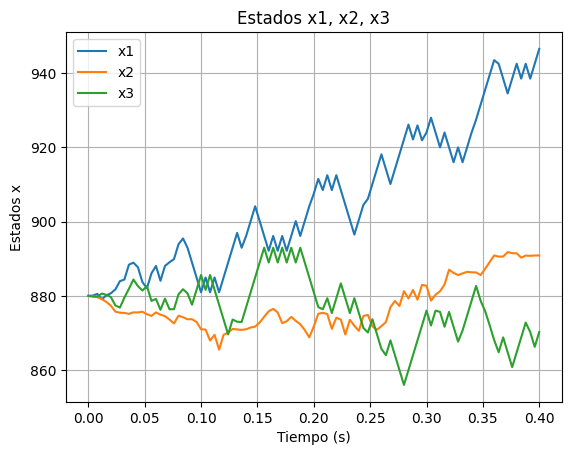

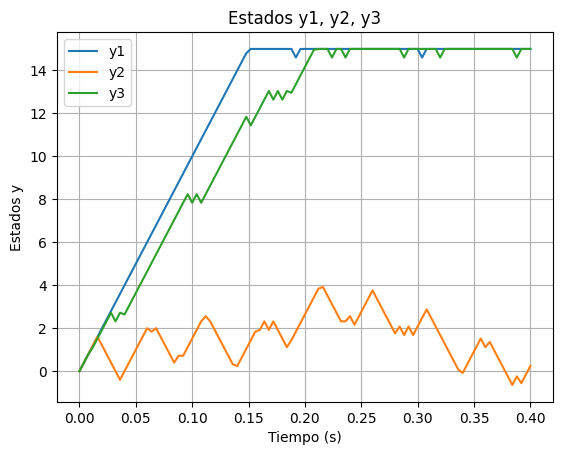

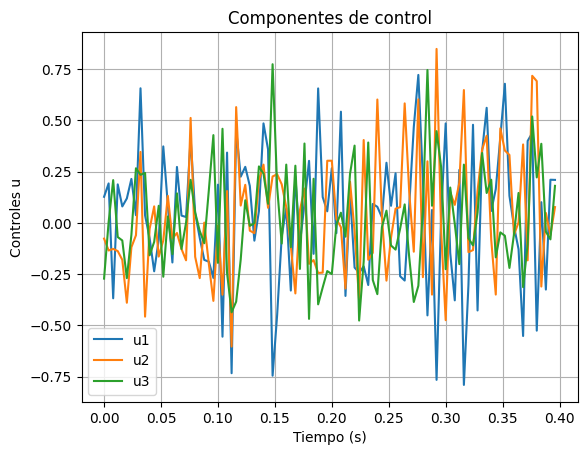

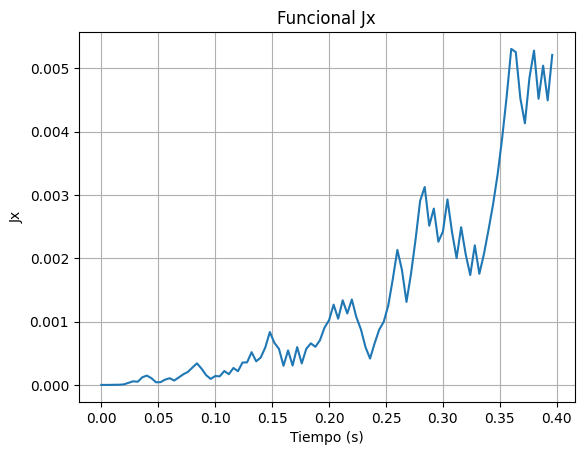

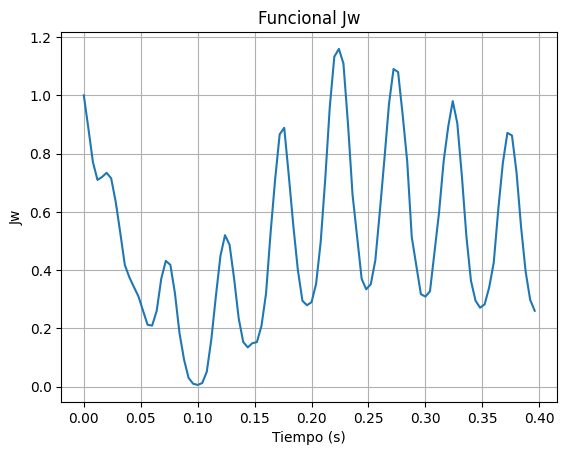

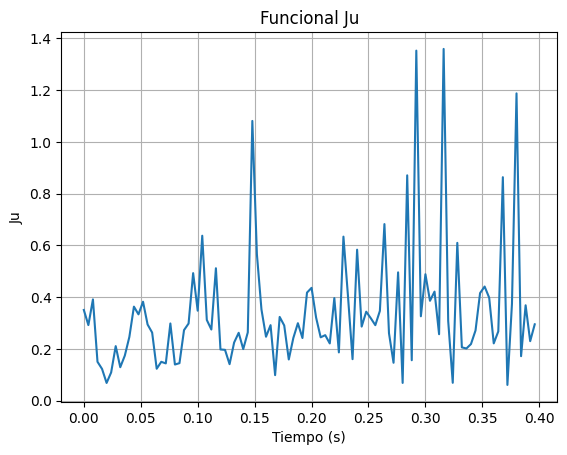

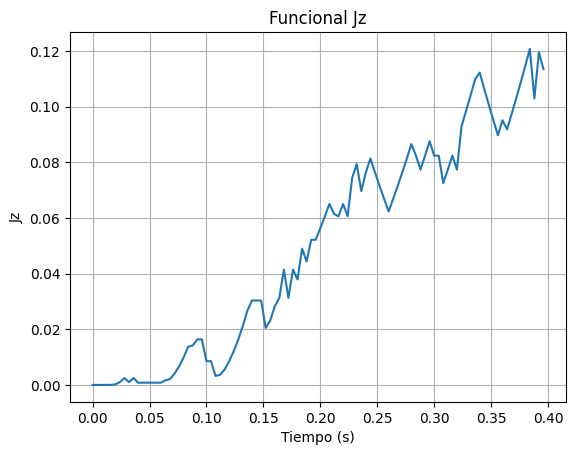

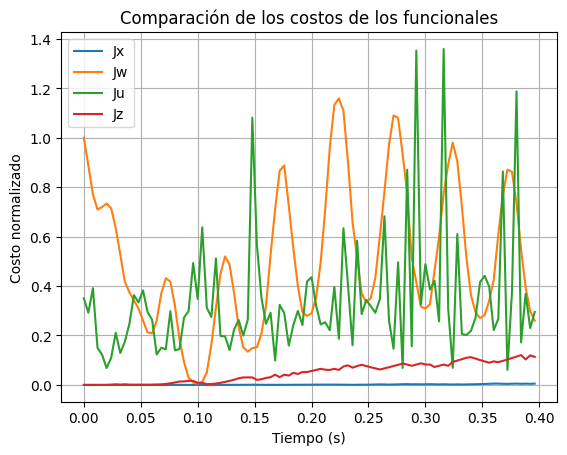

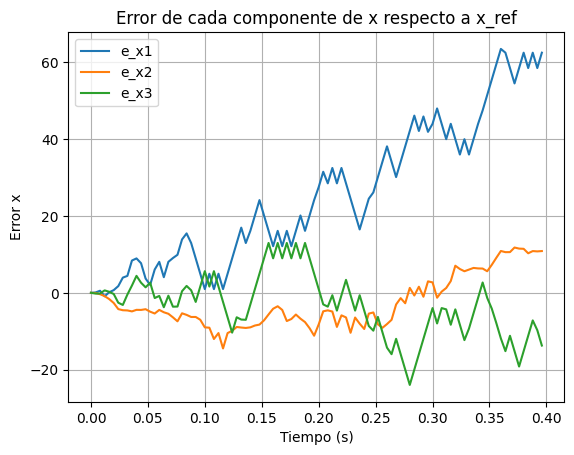

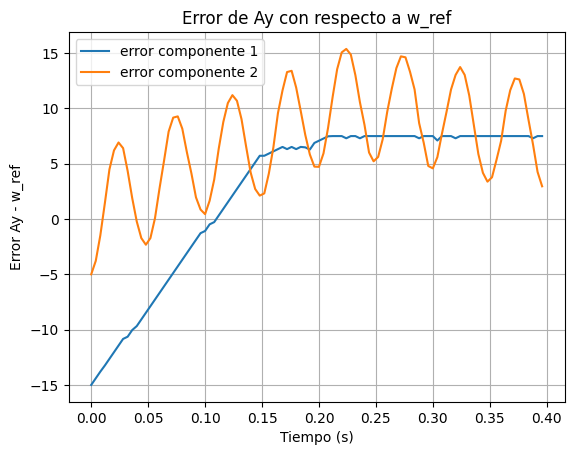

In [2]:

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Asume que ya tienes los arrays `traj` (shape [M,7]) y `ctrls` (shape [N,3])
# en tu entorno, resultantes de control_trajectory_SL(x0).
# -----------------------------------------------------------------------------

# Parámetros de tiempo
T = 0.4
N = ctrls.shape[0]
M = traj.shape[0]
dt = T / N
times = np.linspace(0, T, M)
times_ctrl = times[:-1]

# Extraer estados y controles
x = traj[:, :3]      # x1, x2, x3
y = traj[:, 3:6]     # y1, y2, y3
u = ctrls            # u1, u2, u3

# Arrays para errores y funcionales
e_x_arr = np.zeros((N, 3))
e_w_arr = np.zeros((N, 2))
Jw = np.zeros(N)
Jx = np.zeros(N)
Jz = np.zeros(N)
Ju = np.zeros(N)

# Matrices y referencias
A_mat = np.array([[1., 0., 0.5],
                  [0., 1., 0.5]])
A_pinv = np.linalg.pinv(A_mat)
K_mat = np.array([[ 2/3, -1/3, -1/3],
                  [-1/3,  2/3, -1/3],
                  [-1/3, -1/3,  2/3]])
x_ref = np.array([880., 880., 880.])

# Límites para normalización
e_w_min = np.array([-20., -10.])
e_w_max = np.array([20., 10.])
e_x_min = np.array([-880., -880., -880.])
e_x_max = np.array([120., 120., 120.])
e_z_min = np.array([-15., -15., -15.])
e_z_max = np.array([15., 15., 15.])
e_u_min = np.array([-1000., -1000., -1000.])
e_u_max = np.array([1000., 1000., 1000.])

# Cálculo de E_N^2 para normalización de cada funcional
def EN_sq(e_min, e_max):
    e_DC   = (e_max + e_min) / 2
    e_peak = (e_max - e_min) / 2
    return np.sum(e_DC**2) + 0.5 * np.sum(e_peak**2)

E_w_N_sq = EN_sq(e_w_min, e_w_max)
E_x_N_sq = EN_sq(e_x_min, e_x_max)
E_z_N_sq = EN_sq(e_z_min, e_z_max)
E_u_N_sq = EN_sq(e_u_min, e_u_max)

# -----------------------------------------------------------------------
# 1) Bucle para calcular errores y funcionales en cada paso
# -----------------------------------------------------------------------
for i in range(N):
    t = times_ctrl[i]
    xi = x[i]
    yi = y[i]
    ui = u[i]

    # --- Error de estado x vs x_ref
    ex = xi - x_ref
    e_x_arr[i] = ex

    # --- Error de salida Ay vs w_ref
    w_ref = np.array([15.0, 5.0 * np.cos(40*np.pi*t)])
    ew = yi.dot(A_mat.T) - w_ref
    e_w_arr[i] = ew

    # --- Error z (espacio nulo)
    zmat = np.eye(3) - A_pinv.dot(A_mat)
    ez = yi.dot(zmat.T)

    # --- Error de control u
    d_ref = np.array([500.0, 300.0 * np.cos(40*np.pi*t)])
    ATd = d_ref.dot(A_mat)
    Kxu = (xi * ui).dot(K_mat.T)
    eu = ATd - Kxu

    # Funcionales normalizados
    Jw[i] = np.sum(ew**2) / E_w_N_sq
    Jx[i] = np.sum(ex**2) / E_x_N_sq
    Jz[i] = np.sum(ez**2) / E_z_N_sq
    Ju[i] = np.sum(eu**2) / E_u_N_sq

# -----------------------------------------------------------------------------
# 2) Graficar x1, x2, x3
# -----------------------------------------------------------------------------
plt.figure()
plt.plot(times, x[:,0], label='x1')
plt.plot(times, x[:,1], label='x2')
plt.plot(times, x[:,2], label='x3')
plt.xlabel('Tiempo (s)')
plt.ylabel('Estados x')
plt.title('Estados x1, x2, x3')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 3) Graficar y1, y2, y3
# -----------------------------------------------------------------------------
plt.figure()
plt.plot(times, y[:,0], label='y1')
plt.plot(times, y[:,1], label='y2')
plt.plot(times, y[:,2], label='y3')
plt.xlabel('Tiempo (s)')
plt.ylabel('Estados y')
plt.title('Estados y1, y2, y3')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 4) Graficar controles u1, u2, u3
# -----------------------------------------------------------------------------
plt.figure()
plt.plot(times_ctrl, u[:,0], label='u1')
plt.plot(times_ctrl, u[:,1], label='u2')
plt.plot(times_ctrl, u[:,2], label='u3')
plt.xlabel('Tiempo (s)')
plt.ylabel('Controles u')
plt.title('Componentes de control')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 5) Graficar cada funcional por separado
# -----------------------------------------------------------------------------
for arr, name in zip([Jx, Jw, Ju, Jz], ['Jx', 'Jw', 'Ju', 'Jz']):
    plt.figure()
    plt.plot(times_ctrl, arr)
    plt.xlabel('Tiempo (s)')
    plt.ylabel(name)
    plt.title(f'Funcional {name}')
    plt.grid(True)
    plt.show()

# -----------------------------------------------------------------------------
# 6) Comparación de todos los funcionales en un solo gráfico
# -----------------------------------------------------------------------------
plt.figure()
plt.plot(times_ctrl, Jx, label='Jx')
plt.plot(times_ctrl, Jw, label='Jw')
plt.plot(times_ctrl, Ju, label='Ju')
plt.plot(times_ctrl, Jz, label='Jz')
plt.xlabel('Tiempo (s)')
plt.ylabel('Costo normalizado')
plt.title('Comparación de los costos de los funcionales')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 7) Errores de estado x vs x_ref
# -----------------------------------------------------------------------------
plt.figure()
plt.plot(times_ctrl, e_x_arr[:,0], label='e_x1')
plt.plot(times_ctrl, e_x_arr[:,1], label='e_x2')
plt.plot(times_ctrl, e_x_arr[:,2], label='e_x3')
plt.xlabel('Tiempo (s)')
plt.ylabel('Error x')
plt.title('Error de cada componente de x respecto a x_ref')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 8) Error de salida Ay - w_ref
# -----------------------------------------------------------------------------
plt.figure()
plt.plot(times_ctrl, e_w_arr[:,0], label='error componente 1')
plt.plot(times_ctrl, e_w_arr[:,1], label='error componente 2')
plt.xlabel('Tiempo (s)')
plt.ylabel('Error Ay - w_ref')
plt.title('Error de Ay con respecto a w_ref')
plt.legend()
plt.grid(True)
plt.show()